In [1]:
# Pre-Processing

#importing packages
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from tensorflow.keras import layers, applications, optimizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imgaug import augmenters as iaa
import imgaug as ia

import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
import imutils
import random
import pickle
import cv2
import os
import argparse
import re
from PIL import Image
from numpy import *
from glob import glob
from datetime import datetime
from shutil import copyfile
 
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell #multiple outputs in notebook
InteractiveShell.ast_node_interactivity = "all"            #

random.seed(42)

Using TensorFlow backend.


In [2]:
def plotImages(images_arr, name):
    random.shuffle(images_arr)
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'), cmap = 'gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig('{}.png'.format(name))

In [4]:
dir_dataset = "/Users/annaleid/Documents/Jordy/Cropped Kleur"

In [ ]:
# heavy augmentations
sometimes = lambda aug: iaa.Sometimes(0.4, aug)

seq = iaa.Sequential([
        sometimes(iaa.OneOf([
            iaa.EdgeDetect(alpha=(0.1, 0.8)),
            iaa.Add((-150, 150), per_channel=0.5),
            iaa.AddElementwise((-50, 50), per_channel=0.5),
            iaa.Multiply((0.5, 1.5), per_channel=0.2)
            ])),
    
        sometimes(iaa.Affine(
            rotate=(-2, 2),
            shear=(-2, 2),
            )),
    
        iaa.SomeOf((1,3), [
            iaa.Sharpen(alpha=(0, 0.8), lightness=(0.75, 1.5)),
            iaa.ContrastNormalization((0.75, 1.25), per_channel = 0.5),
            iaa.OneOf([
                iaa.AdditiveGaussianNoise(scale=(0.0, 0.01*255), per_channel = True),
                iaa.AdditiveLaplaceNoise(scale=0.01*255),
                iaa.SaltAndPepper(p=(0, 0.05))
                ]),
        ]),
        
         sometimes(iaa.WithColorspace(
            to_colorspace="HSV",
            from_colorspace="RGB",
            children=iaa.WithChannels(0, iaa.Add((0, 50))
            )
        )),
    
    
        sometimes(iaa.OneOf([
            iaa.OneOf([
                iaa.GaussianBlur((1)),
                iaa.AverageBlur(k=(1)),
                iaa.MedianBlur(k=(1)),
            ]),

    ]))

], random_order = False)

In [ ]:
# light augmentations
sometimes = lambda aug: iaa.Sometimes(0.4, aug)

seq = iaa.Sequential([
        sometimes(iaa.OneOf([
            iaa.DirectedEdgeDetect(alpha=(0.1, 0.8), direction=(0.0, 1.0)),
            iaa.Add((-150, 150), per_channel=0.5),
            iaa.Invert(0.25),
            iaa.Multiply((0.8, 1.2), per_channel=0.2)
            ])),
        sometimes(iaa.Affine(
            scale={"x": (0.85, 1.15), "y": (0.85, 1.15)},
            translate_percent={"x": (-0.10, 0.10), "y": (-0.1, 0.1)},
            rotate=(-2, 2),
            shear=(-1, 1))
            ),
        iaa.SomeOf((2,3), [
            iaa.AdditiveGaussianNoise(scale=(0, 0.02*255)),
            iaa.Sharpen(alpha=(0, 0.8), lightness=(0.80, 1.3)),
            iaa.ContrastNormalization((0.80, 1.20), per_channel = 0.5),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            iaa.SaltAndPepper(p=(0, 0.05))
            ]),
], random_order = True)

In [ ]:
# create off-line augmentations
  
INPUT = dir_dataset
OUTPUT = dir_dataset + "/notes_aug"
WHITE_LIST_FORMAT = ('png', 'PNG', 'jpg', 'jpeg', 'bmp', 'ppm', 'JPG')
ITERATIONS = 120
 
def check_dir_or_create(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
 
files = [y for x in os.walk(INPUT) for y in glob(os.path.join(x[0], '*')) if os.path.isfile(y)]
train_files = [f for f in files if f.endswith(WHITE_LIST_FORMAT)]
classes = [os.path.basename(os.path.dirname(x)) for x in files]
classes_set = set(classes)
for _class in classes_set:
    _dir = os.path.join(OUTPUT, _class)
    check_dir_or_create(_dir)
 
batches = []
BATCH_SIZE = 30
batches_count = len(files) // BATCH_SIZE + 1
for i in range(batches_count):
    batches.append(train_files[BATCH_SIZE * i:BATCH_SIZE * (i + 1)])
 
images = []
for i in range(ITERATIONS):
    print(i, datetime.time(datetime.now()))
    for batch in batches:
        images = []
        for file in batch:
            img = cv2.imread(file)
            images.append(img)
        images_aug = seq.augment_images(images)
        for file, image_aug in zip(batch, images_aug):
            root, ext = os.path.splitext(file)
            new_filename = root + '_{}'.format(i) + ext
            new_path = new_filename.replace(INPUT, OUTPUT, 1)
                        
            plt.imsave(new_path, image_aug)

In [7]:
# Create list with arrays and labels of images
OUTPUT = dir_dataset + "/notes_aug"
# initialize image dimensions
IMAGE_DIMS = (158, 100, 3)
scale_percent = 100

width = int(IMAGE_DIMS[1] * scale_percent / 100)
height = int(IMAGE_DIMS[0] * scale_percent / 100)

# dsize
dsize = (width, height)

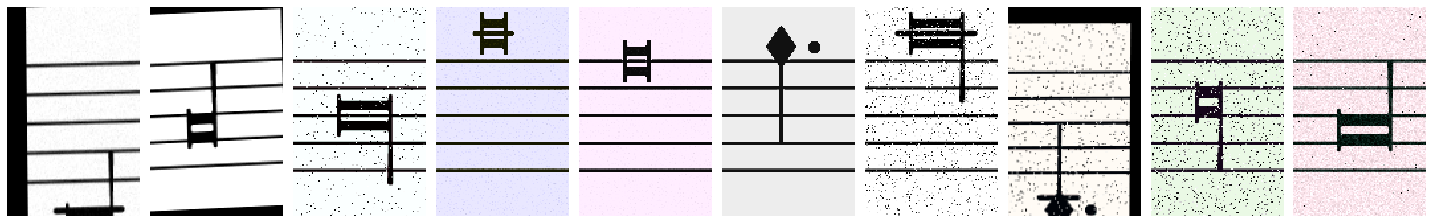

In [11]:
# Show Example Database
imagePaths = sorted(list(paths.list_images(OUTPUT)))
random.shuffle(imagePaths)
images_train = []

for imagePath in imagePaths[:10]:
    image = cv2.imread(imagePath)
    images_train.append(image)

plotImages(images_train, 'aug_heavy')